In [1]:
import argparse
import cv2
import numpy as np
import os
from imantics import Mask
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# 读取数据

In [123]:
x_list = []
y_list = []
sift = cv2.SIFT_create()
null_gray = np.zeros((640, 640), np.uint8)
null_img = np.zeros((640, 640), np.uint8)
for pic in tqdm(os.listdir('obj_aug')[:1]):
    pic_path = './obj_aug/' + pic
    img = cv2.imread(pic_path)
    gray = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    # 得到SIFT特征点
    kp = sift.detect(gray, None)
#     img = cv2.drawKeypoints(gray, kp, img)
    img = cv2.drawKeypoints(null_gray, kp, null_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pic_data = cv2.resize(img, (160, 160))
    x_list.append(pic_data)
    y_list.append(int(pic[:2]))
x_list = np.array(x_list)  # (15000, 160, 160, 3)
y_list = np.array(y_list)

  0%|          | 0/1 [00:00<?, ?it/s]

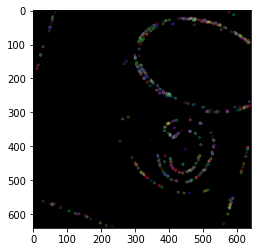

In [124]:
plt.imshow(img)
plt.savefig('kp.pdf')

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

# 假设标签数据保存在label_list中，其中每个标签是一个整数
X = x_list
y = y_list

# 分层抽样，其中train_size和test_size分别表示训练集和测试集的比例
# n_splits表示抽取的次数，random_state表示随机数种子
split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=42)
train_index, test_index = next(split.split(X, y))

# 得到训练集和测试集
X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

# 加载数据集
train_data = np.array(X_train)
train_labels = np.array(y_train)
test_data = np.array(X_test)
test_labels = np.array(y_test)

# 将图片矩阵转换为向量
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)

In [35]:
train_data.shape

(12000, 25600)

# 特征提取方法
## 增量PCA

In [94]:
from sklearn.decomposition import IncrementalPCA

n_batches = 10
inc_pca = IncrementalPCA(n_components=20)

for X_batch in tqdm(np.array_split(train_data, n_batches)):
    inc_pca.partial_fit(X_batch)

  0%|          | 0/10 [00:00<?, ?it/s]

In [95]:
train_data_inc_pca = inc_pca.transform(train_data)
test_data_inc_pca = inc_pca.transform(test_data)

## 随机PCA

In [97]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20, svd_solver='randomized')
pca.fit(train_data)
train_data_inc_pca = pca.transform(train_data)
test_data_inc_pca = pca.transform(test_data)

## t-SNE

In [101]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3)
train_data_inc_pca = tsne.fit_transform(train_data)
test_data_inc_pca = tsne.fit_transform(test_data)

## FactorAnalysis

In [79]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=20)
fa.fit(train_data)
train_data_inc_pca = fa.transform(train_data)
test_data_inc_pca = fa.transform(test_data)

## MiniBatchSparsePCA

In [99]:
from sklearn.decomposition import MiniBatchSparsePCA

pca = MiniBatchSparsePCA(n_components=20)
pca.fit(train_data)
train_data_inc_pca = pca.transform(train_data)
test_data_inc_pca = pca.transform(test_data)

# 分类器

In [102]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

0.078

In [103]:
from sklearn.linear_model import PassiveAggressiveClassifier

clf = PassiveAggressiveClassifier(random_state=0)
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

0.06233333333333333

In [104]:
from sklearn.linear_model import Perceptron

clf = Perceptron(random_state=0)
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

0.044333333333333336

In [105]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(random_state=0)
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

0.08

In [106]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(random_state=0)
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

C:\Users\hs-wang17\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.063

In [107]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(random_state=0)
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

0.06666666666666667

In [108]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(random_state=0)
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

0.07233333333333333

In [109]:
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(random_state=0)
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

0.058

In [110]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(random_state=0)
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

0.06733333333333333

In [111]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

0.063

In [112]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

0.057666666666666665

In [113]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=0)
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

0.08366666666666667

In [114]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_data_inc_pca, train_labels)
clf.score(test_data_inc_pca, test_labels)

0.056